In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import yfinance as yf
import os
from pathlib import Path
from google.colab import drive

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Especificando o caminho padrão do projeto:
pasta = str("/content/drive/MyDrive/Python/TCC-Cloud/Clustering/result_clustering/")
pasta

'/content/drive/MyDrive/Python/TCC-Cloud/Clustering/result_clustering/'

In [4]:
# Coleta da taxa de retorno risk free

def deannualize(annual_rate, periods=365):
    return (1 + annual_rate) ** (1/periods) - 1

annualized = yf.download("^IRX", start="1995-01-01", end="2023-12-31")["Adj Close"]
daily = annualized.apply(deannualize)

# create dataframe
risk_free_rates = pd.DataFrame({"annualized": annualized, "daily": daily})
risk_free_rates['daily'] = risk_free_rates['daily'] / 100
print(np.shape(risk_free_rates))
risk_free_rates.head()

[*********************100%%**********************]  1 of 1 completed


(7282, 2)


,annualized,daily
Date,,
1995-01-03,5.52,0.000051
1995-01-04,5.69,0.000052
1995-01-05,5.71,0.000052
1995-01-06,5.74,0.000052
1995-01-09,5.75,0.000052


In [5]:
operations = pd.read_csv(pasta + "operations_CT.csv")
#operations['Pair'] = operations['Index'].str[:-2]
operations['Pair'] = operations['Ticker 1'] + "-" + operations['Ticker 2']
print(operations.tail())

     Operação  Semestre  Abertura  Fechamento  Dias  Retorno total Ticker 1  \
261         1        53         2          52    50       0.016913    PETR4   
262         1        54       113         127    14      -0.018497    RRRP3   
263         1        54       124         127     3       0.001126    BRAP4   
264         1        54       124         127     3       0.008862    VALE3   
265         1        54        28          52    24       0.058111    EGIE3   

    Ticker 2  Converged          Index  Retorno total - exp         Pair  
261    PETR3       True  PETR4-PETR3-1             1.017057  PETR4-PETR3  
262    SLCE3      False  RRRP3-SLCE3-1             0.981673  RRRP3-SLCE3  
263    SLCE3      False  BRAP4-SLCE3-1             1.001127  BRAP4-SLCE3  
264    SLCE3      False  VALE3-SLCE3-1             1.008901  VALE3-SLCE3  
265    TRPL4       True  EGIE3-TRPL4-1             1.059833  EGIE3-TRPL4  


In [6]:
#print(f"Converged operations: {sum(operations['Converged'])} | Open operations: {np.shape(operations)[0] - sum(operations['Converged'])}")
print(f"Número de operações: {np.shape(operations)[0]}")
print(f"Positive Returns: {sum(operations['Retorno total'] > 0)} | Negative: {sum(operations['Retorno total'] < 0)}")
print(f"Highest Return: {operations['Retorno total'].max()}")
print(f"Lowest Return: {operations['Retorno total'].min()}")
print(f"Average Return: {operations['Retorno total'].mean()}")
print(f"Average trade lenght: {operations['Dias'].mean()}")
print(f"Convergência: {(operations['Converged'].sum()/np.shape(operations)[0])*100}")

Número de operações: 266
Positive Returns: 239 | Negative: 24
Highest Return: 1.66118309886613
Lowest Return: -0.4729967112375206
Average Return: 0.10854169999691238
Average trade lenght: 17.827067669172934
Convergência: 69.92481203007519


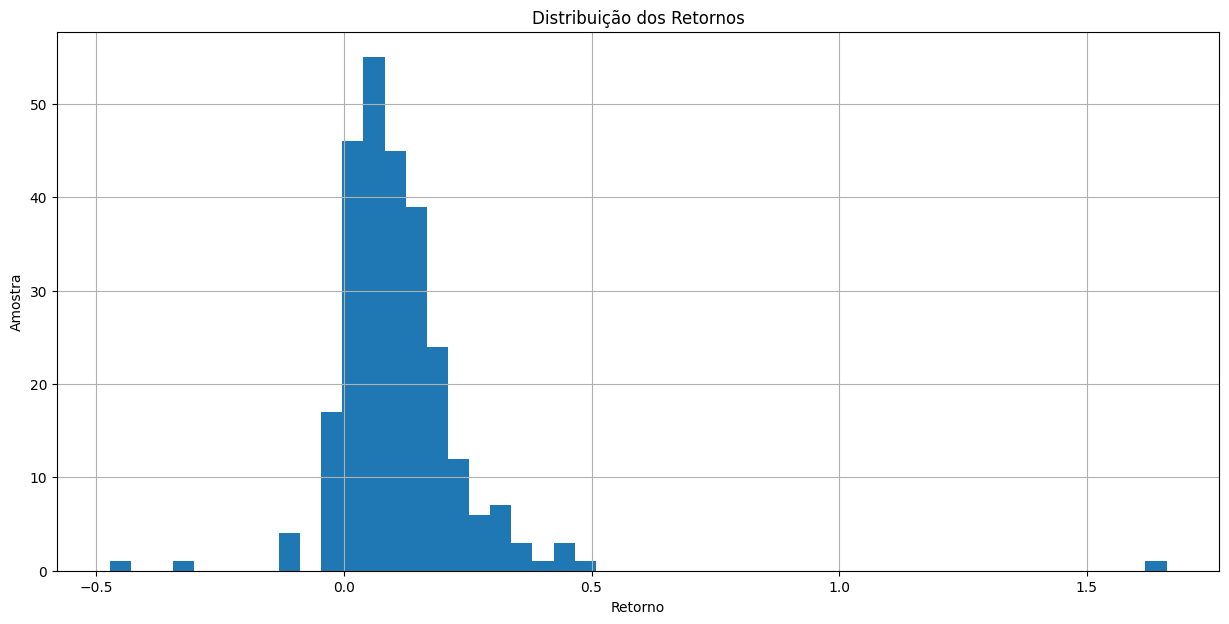

In [7]:
# Return Distribution
fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(1, 1, 1)
operations['Retorno total'].hist(bins=50, ax=ax1)
ax1.set_xlabel('Retorno')
ax1.set_ylabel('Amostra')
ax1.set_title('Distribuição dos Retornos')
plt.show()

In [8]:
# Retorno por par
operations_by_pair = operations.groupby("Pair").sum("Retorno total")
print(f"Número de pares: {np.shape(operations_by_pair)[0]}")
print(f"Retorno médio por par: {round(100*operations_by_pair['Retorno total'].mean(),4)}%")
print(f"Retorno médio por par por semestre: {round(np.divide(100*operations_by_pair['Retorno total'].mean(),max(operations['Semestre'])+1),4)}%")

Número de pares: 179
Retorno médio por par: 16.1297%
Retorno médio por par por semestre: 0.2933%


In [9]:
# Ações com maior participação
stock_count = {}

for pair in operations_by_pair.index:
    stocks = pair.split("-")
    for stock in stocks:
        if stock in stock_count:
            stock_count[stock] += 1
        else:
            stock_count[stock] = 1
stock_count_df = pd.DataFrame(stock_count.items())
stock_count_df = stock_count_df.sort_values(1)
stock_count_df.to_csv(pasta + "stock_count_20_pairs.csv")
print(stock_count_df)

        0   1
66  CRUZ3   1
42  BRML3   1
43  ALLL3   1
55  CLSC4   1
58  YDUQ3   1
..    ...  ..
49  BRDT4   8
50    old   8
62  PCAR4   8
5   VIVT4   9
16  OIBR3  13

[134 rows x 2 columns]


Compound interest rate is [0.] %


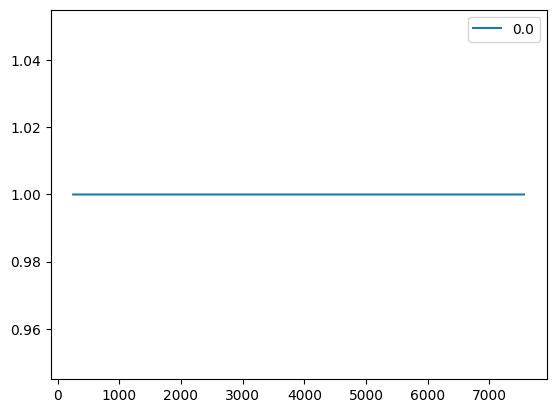

In [10]:
def rate_interest(principal, final_amount, time):
    rate = (100 * (final_amount/principal)**(1/time)) - 100
    print("Compound interest rate is", rate, "%")

daily_returns = pd.read_csv(pasta + "daily_returns.csv")
daily_returns = daily_returns.iloc[252:,:]
daily_returns = daily_returns / 35
cumulative = np.cumprod(1+daily_returns)
cumulative.plot()
rate_interest(1,cumulative.values[-1],25)

In [11]:
# Cálculo do Sharpe para o período do estudo
mean_daily_return = daily_returns.values.mean()
print(f"Mean daily return: {mean_daily_return}")
returns_std_dev = daily_returns.values.std()

risk_free_mean = risk_free_rates['daily'].mean()
print(f"Mean risk free return: {risk_free_mean}")

print(f"Fully Invested Sharpe Ratio: {(mean_daily_return - risk_free_mean) / returns_std_dev}")

Mean daily return: 0.0
Mean risk free return: 2.548781546595671e-05
Fully Invested Sharpe Ratio: -inf


<ipython-input-11-06e38a554792>:9: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"Fully Invested Sharpe Ratio: {(mean_daily_return - risk_free_mean) / returns_std_dev}")


Rascunho:

In [12]:
operations['Retorno total'].sum()

28.87209219917869

In [13]:
np.sum(daily_returns)

0.0    0.0
dtype: float64

In [14]:
operations_by_pair

,Operação,Semestre,Abertura,Fechamento,Dias,Retorno total,Converged,Retorno total - exp
Pair,,,,,,,,
ABEV3-BRPR3,3,84,144,187,43,0.030521,1,2.031211
ABEV3-RADL3,3,76,116,128,12,0.087581,2,2.089530
ABEV3-SULA11,1,32,116,130,14,0.013248,0,1.013336
ACES4-VIVT4,6,54,90,116,26,0.452215,3,3.488253
AMBV4-SUZB5,1,5,1,15,14,0.213606,1,1.238135
...,...,...,...,...,...,...,...,...
VIVT3-BRPR3,3,94,58,109,51,0.146293,2,2.151902
VIVT3-CGAS5,1,44,35,50,15,0.100038,1,1.105213
VIVT3-ENGI11,3,90,83,125,42,0.090406,2,2.092761


In [15]:
operations_by_pair['Retorno total'].mean()

0.16129660446468544

In [16]:
stock_count_df

,0,1
66,CRUZ3,1
42,BRML3,1
43,ALLL3,1
55,CLSC4,1
58,YDUQ3,1
...,...,...
49,BRDT4,8
50,old,8
62,PCAR4,8
5,VIVT4,9


In [17]:
max(operations['Semestre'])+1

55